In [2]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.7.0+cu128


In [3]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
def make_generator_network(input_size=20, num_hidden_layers=1, num_hidden_units=100, num_output_units=784):
    # 20 -[fc+Leaky-ReLU]-> 100 -[fc+tanh]-> 784 -[reshape]-> \~x (28x28)
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())
    return model

def make_discriminator_network(input_size, num_hidden_layers=1, num_hidden_units=100, num_output_units=1):
    # x or \~x (28x28) -[reshape]-> 784 -[fc+Leaky-ReLU]-> 100 -[fc+sigmoid]-> probability
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module(f'dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())
    return model

In [10]:
image_size = (28, 28)
z_size = 20

gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)
)
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [12]:
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size,
)
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=True)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
import torchvision
from torchvision import transforms

image_path = '../data/'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=False)
example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [16]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [18]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
# print(input_real.shape)
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)

print('input-z -- shape:', input_z.shape)
print('input-real --shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real --shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [19]:
loss_fn = nn.BCELoss()

g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6801
Discriminator Losses: Real 0.7874 Fake 0.7068


In [42]:
batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

gen_model = make_generator_network(z_size, gen_hidden_layers, gen_hidden_size, np.prod(image_size)).to(device)
disc_model = make_discriminator_network(np.prod(image_size), disc_hidden_layers, disc_hidden_size).to(device)

loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [23]:
def d_train(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [24]:
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [50]:
import time
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 5
torch.manual_seed(1)
t = time.time()
for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-real: {all_d_real[-1]:.4f} D-fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

print('training time:', time.time() - t)

Epoch 001 | Avg Losses >> G/D 1.0078/1.1016 [D-real: 0.6240 D-fake: 0.4106]
Epoch 002 | Avg Losses >> G/D 1.0628/1.1077 [D-real: 0.6216 D-fake: 0.3943]
Epoch 003 | Avg Losses >> G/D 1.0425/1.1548 [D-real: 0.5973 D-fake: 0.3985]
Epoch 004 | Avg Losses >> G/D 0.9236/1.2140 [D-real: 0.5763 D-fake: 0.4257]
Epoch 005 | Avg Losses >> G/D 1.0913/1.1203 [D-real: 0.6142 D-fake: 0.3888]
training time: 67.98396015167236


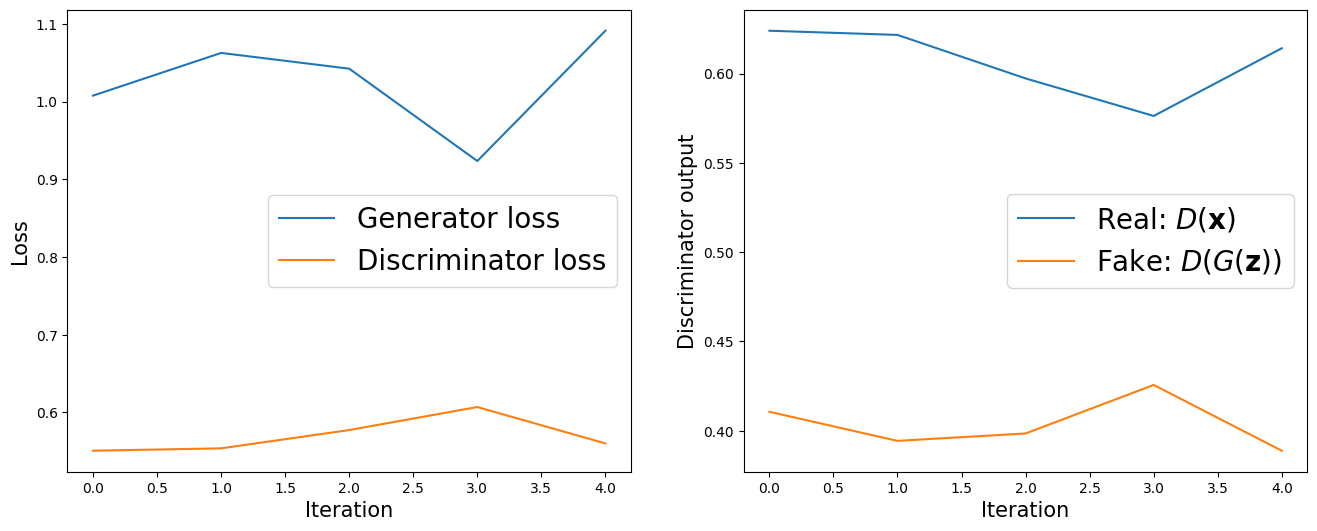

In [51]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
 
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

#plt.savefig('figures/ch17-gan-learning-curve.pdf')
plt.show()

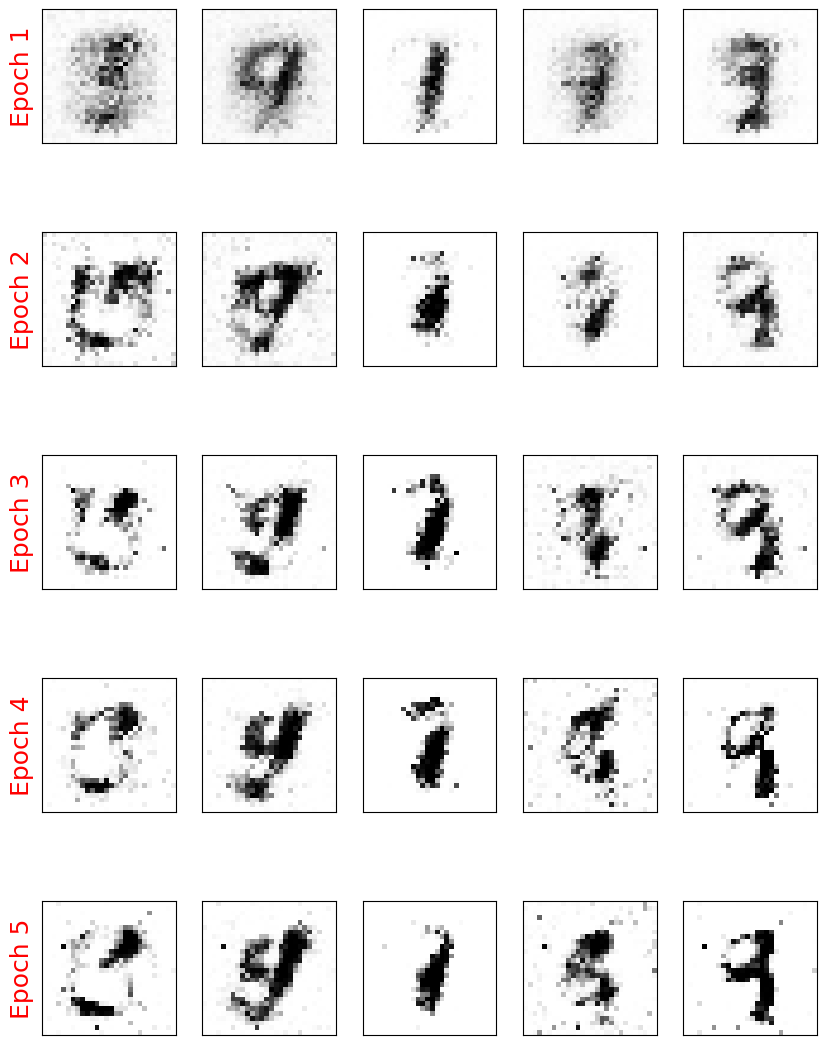

In [52]:
selected_epochs = [1, 2, 3, 4, 5]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(5, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('figures/ch17-vanila-gan-samples.pdf')
plt.show()